In [1]:
import torch
from torch import nn 
from d2l import torch as d2l
import math

自注意力机制公式：
$$
y_i=f\left( x_i,\left( x_1,x_1 \right) ,.....,\left( x_n,x_n \right) \right) 
$$

In [2]:
num_hiddens , num_heads = 100 , 5
#五头注意力，注意返回的是( batch_size , 查询个数 , num_hiddens )
attention = d2l.MultiHeadAttention( num_hiddens , num_hiddens , num_hiddens , num_hiddens , num_heads , 0.5  )
attention.eval()

MultiHeadAttention(
  (attention): DotProductAttention(
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (W_q): Linear(in_features=100, out_features=100, bias=False)
  (W_k): Linear(in_features=100, out_features=100, bias=False)
  (W_v): Linear(in_features=100, out_features=100, bias=False)
  (W_o): Linear(in_features=100, out_features=100, bias=False)
)

In [3]:
batch_size, num_queries, valid_lens = 2, 4, torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
attention(X, X, X, valid_lens).shape

torch.Size([2, 4, 100])

In [4]:
a = torch.randn(2,4,3)
a[:,:,0::2]

tensor([[[-1.0181,  0.4117],
         [ 1.0248, -0.2827],
         [-0.8020, -0.8075],
         [ 0.3735,  3.3590]],

        [[-0.8038,  0.8793],
         [-0.2675, -0.9169],
         [ 0.3610,  0.1401],
         [-0.6640,  0.0514]]])

In [5]:
torch.arange( 0, 32 ,2 )

tensor([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30])

In [6]:
torch.pow(10000, torch.arange(
            0, 32, 2, dtype=torch.float32)/32)

tensor([1.0000e+00, 1.7783e+00, 3.1623e+00, 5.6234e+00, 1.0000e+01, 1.7783e+01,
        3.1623e+01, 5.6234e+01, 1.0000e+02, 1.7783e+02, 3.1623e+02, 5.6234e+02,
        1.0000e+03, 1.7783e+03, 3.1623e+03, 5.6234e+03])

In [7]:
class PositionalEncoding( nn.Module ):
    '''位置编码'''
    def __init__( self , num_hiddens , dropout , max_lens = 1000 ):
        super().__init__()
        self.dropout = nn.Dropout( dropout )
        #创建一个足够长的编码'P',这里的shape就是(1,1000,32)
        self.P = torch.zeros( 1 , max_lens , num_hiddens )
        #生成一个位置信息X，实现max_len行的位置信息，然后除以 torch.pow( 1000 ,  2j/d )，得到了所谓的位置编码
        X = torch.arange( max_lens , dtype= torch.float32 ).reshape( -1 , 1 ) / torch.pow( 10000 , torch.arange( 0 , num_hiddens , 2 , dtype= torch.float32 ) / num_hiddens )
        self.P[: , : ,  0::2 ] = torch.sin( X )#从零位置开始以步长为2将位置编码传入，此时会将奇数列空出
        self.P[ : , : , 1::2 ] = torch.cos( X )#从一位置开始以步长为2将位置编码传入，此时会填补所有的奇数列的位置信息，
        # 此时矩阵p存有1000个位置信息，注意，每个位置信息的shape都是( 1 ,1 , 32 ),现在我们有1000个位置信息，所以我们要将矩阵p的shape设置成( 1 , 1000 , 32 )
    
    def forward( self , X ):
        #这一步就是将位置信息按照X的shape[1],在文本内就是多少个词元。
        X = X + self.P[ :  , :X.shape[1] , : ].to( X.device )
        return self.dropout( X )

In [9]:
encoding_dim , num_steps = 32, 60
pos_encodeing = PositionalEncoding( encoding_dim , 0  ).eval()
X = pos_encodeing( torch.zeros( 1 , num_steps , encoding_dim ) )
P = pos_encodeing.P[: , :X.shape[1] , : ]#取出X.shape[1]的时间步个数
print( P.shape )

torch.Size([1, 60, 32])


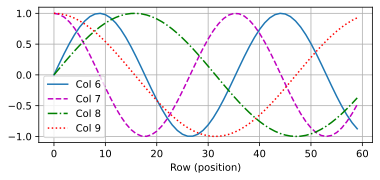

In [10]:
d2l.plot(torch.arange(num_steps), P[0, :, 6:10].T, xlabel='Row (position)',
         figsize=(6, 2.5), legend=["Col %d" % d for d in torch.arange(6, 10)])